In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import numpy as np
from scipy.interpolate import splrep, splev
import scipy as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

## Trend filtering after spatial denoising

In [2]:
from trendFiltering.trendfilter import TF, TFsafe, TFsafeG

### code of L1-TF
http://www.cvxpy.org/en/1.0/examples/applications/l1_trend_filter.html

In [3]:
import cvxpy as cvx
import cvxopt as cvxopt


def L1TF_D2(y, vlambda=50):
    y = y[:,np.newaxis]
    n = y.size
    # Form second difference matrix.
    e = np.mat(np.ones((1, n)))
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
    # D_coo = D.tocoo()
    # D = cvxopt.spmatrix(D_coo.data, D_coo.row.tolist(), D_coo.col.tolist())
    
    # Solve l1 trend filtering problem.
    x = cvx.Variable(rows=n)
    obj = cvx.Minimize(0.5 * cvx.sum_squares(y - x) + vlambda * cvx.norm(D*x, 1) )
    prob = cvx.Problem(obj)
    # ECOS and SCS solvers fail to converge before the iteration limit. Use CVXOPT instead.
    prob.solve(solver=cvx.CVXOPT,verbose=True)
    
    print('Solver status: %s'%(prob.status))
    # Check for error.
    if prob.status != cvx.OPTIMAL:
        raise Exception("Solver did not converge!")
    return x.value

def lambda_max_D2(y):
    y = y[:,np.newaxis]
    n = y.size
    e = np.mat(np.ones((1, n)))
    D = sp.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n).todense()
    return np.linalg.norm(np.dot(np.linalg.pinv(D.T), y), ord=np.inf)

### Simulated data

In [4]:
xp = np.array([1, 100, 150, 260, 300, 350, 400], dtype='float64')
yp = np.array([3, 10, -2, -5, 9, 2, 6], dtype='float64')
x = np.linspace(1, 400, num=400)
spl = splrep(xp, yp)
y = splev(x, spl)
y = y + np.random.normal(size = y.shape)*5

#### Zheng Han's code

---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------
---------------------------------------------------
  IT       OBJ  #VIO     |VIO| |neg| |act| |pos|
---------------------------------------------------


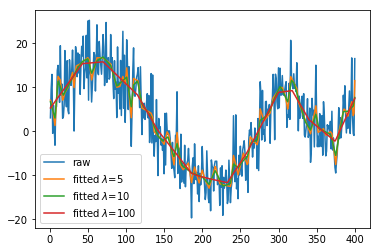

In [5]:
plt.plot(x, y, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob = TF(y[:,np.newaxis],lam,order=2,mode = -1)
    prob.silence = True
    prob.pdas()
    plt.plot(x, prob.x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()    

#### Code above

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  3e+05  9e+00  4e-01  1e+00
 1:  4.9407e+02  5.0448e+02  4e+05  9e+00  4e-01  1e+01
 2: -1.3267e+02 -3.8482e+00  3e+05  7e+00  3e-01  1e+02
 3: -4.7907e+01  3.6773e+01  1e+05  4e+00  2e-01  9e+01
 4:  6.6196e+02  7.5219e+02  1e+05  4e+00  2e-01  9e+01
 5:  3.5094e+02  4.1218e+02  4e+04  1e+00  7e-02  6e+01
 6:  1.2314e+03  1.2813e+03  3e+04  1e+00  5e-02  5e+01
 7:  1.1519e+03  1.1723e+03  1e+04  5e-01  2e-02  2e+01
 8:  2.2630e+03  2.2865e+03  2e+04  5e-01  2e-02  2e+01
 9:  1.9030e+03  1.9148e+03  9e+03  3e-01  1e-02  1e+01
10:  3.0148e+03  3.0205e+03  4e+03  1e-01  6e-03  6e+00
11:  3.1601e+03  3.1634e+03  3e+03  7e-02  3e-03  3e+00
12:  3.7116e+03  3.7162e+03  4e+03  8e-02  4e-03  5e+00
13:  3.5825e+03  3.5845e+03  2e+03  4e-02  2e-03  2e+00
14:  3.8986e+03  3.8991e+03  5e+02  1e-02  5e-04  6e-01
15:  3.9689e+03  3.9690e+03  1e+02  2e-03  9e-05  1e-01
16:  3.9826e+03  3.9827e+03  2e+01  4e-04  2e-05  

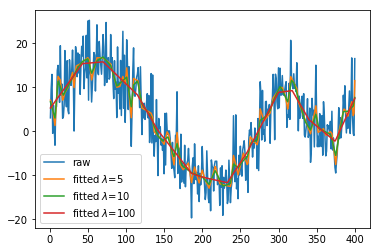

In [6]:
plt.plot(x, y, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob_x = L1TF_D2(y, vlambda=lam)
    plt.plot(x, prob_x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show() 

In [ ]:
x = np.linspace(1, 600, num=40000)
y = np.cos(x**2/10000*np.pi)
y = y + np.random.normal(size = y.shape)*0.45 * np.sqrt(400/40000)
prob = TFsafeG(y[:,np.newaxis],5*np.sqrt(40000/400),order=2,mode = -1)
prob.silence = False
prob.pdas()
plt.plot(x, y)
plt.plot(x, prob.x)


In [ ]:
timeList = []
sizeData = [100, 400, 800, 1200, 1600, 2000]
for nData in sizeData:
    x = np.linspace(1, 400, num=nData)
    y = np.cos(x**2/10000*np.pi)
    y = y + np.random.normal(size = y.shape)*0.45
    prob = TFsafe(y[:,np.newaxis],5,order=2,mode = -1)
    prob.silence = True
    prob.pdas()
    timeList.append(prob.info['time'])

In [ ]:
plt.plot(sizeData, timeList, 'ob')

### Load TK's data

In [8]:
cropSDN = sp.io.loadmat('cropSDN.mat')['cropSDN'][0]
x = np.arange(cropSDN.shape[0])
plt.plot(x, cropSDN, label='raw')
weights = np.ones(max(y.shape))
for lam in [5, 10, 100]:
    prob = TFsafe(cropSDN[:,np.newaxis],lam,order=1,mode = -1)
    prob.pdas()
    plt.plot(x, prob.x, label='fitted $\lambda$=%d'%(lam))
plt.legend()
plt.show()

AttributeError: module 'scipy' has no attribute 'io'